# ダイナミックヘッジ

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import ivolat3

In [3]:
s_df = pd.read_pickle('./data/s.pickle')
op_pn = pd.read_pickle('./data/op1.pickle')

s_df = s_df.loc['2018-02-26 15:15':'2018-03-07 15:15:00']
op_pn = op_pn.loc['2018-02-26 15:15':'2018-03-07 15:15:00']

df = pd.DataFrame([op_pn.loc[ix].loc[22250] for ix in op_pn])
df.index = op_pn.keys()
df['s'] = s_df['1803']
put_ix = df['Call/Put'] == 'P'
df.loc[put_ix, 'price'] = df.loc[put_ix].apply(
    lambda x: x['s'] - 22250 + x['price'], axis=1)
df.drop('Call/Put', axis=1, inplace=True)
df['t'] = (pd.to_datetime('2018-03-09 9:00') -
           df.index).map(lambda x: (x.days + x.seconds / 60 / 60 / 24) / 365)
df['delta'] = df.apply(lambda x: ivolat3.delta_call(
    x['s'], 22250, 0.001, 0, x['t'], x['iv']), axis=1)

## オプションプレミアムとデルタ

* 期間: 2018/02/26 - 2018/03/07
* 権利行使価格: 2018年3月限コール22250(ATM)

列名|値
---|---
price|コールオプションのプレミアム
iv|ボラティリティ
s|先物価格
t|満期までの期間
delta|オプションのデルタ

In [4]:
df

,price,iv,s,t,delta
2018-02-26 15:15:00,261.13600,0.183005,22214.1,0.029424,0.486102
2018-02-27 15:15:00,353.09200,0.196899,22375.4,0.026684,0.575975
2018-02-28 15:15:00,205.30100,0.201231,22095.6,0.023944,0.417880
2018-03-01 15:15:00,72.13110,0.215770,21644.4,0.021204,0.194370
2018-03-02 15:15:00,23.57470,0.256367,21137.2,0.018465,0.072851
2018-03-05 15:15:00,8.06818,0.306589,20997.1,0.010245,0.032029
2018-03-06 15:15:00,11.44550,0.266243,21438.9,0.007506,0.055012
2018-03-07 15:15:00,4.83726,0.356209,21194.7,0.004766,0.024797


### 先物価格/オプションプレミアム/デルタの推移

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f092a7ef6a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f092827a978>], dtype=object)

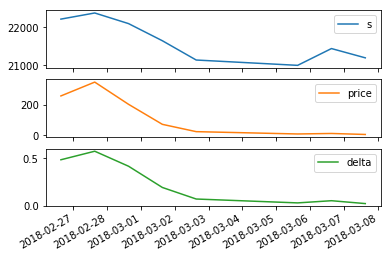

In [5]:
df[['s', 'price', 'delta']].plot(subplots=True)

In [6]:
def get_returns(df, i):
    hedge = df.iloc[i, df.columns.get_loc('hedge')]
    s0 = df.iloc[i, df.columns.get_loc('s')]
    returns = (df.iloc[i + 1:, df.columns.get_loc('s')] - s0) * hedge
    returns.name = hedge
    return returns


hedge = -(df['delta'] - df['delta'].shift(1)).round(2)
hedge[0] = df.iloc[0, df.columns.get_loc('delta')].round(2) * -1
df['hedge'] = hedge
hedge_returns_df = pd.concat([get_returns(df, i)
                              for i in range(len(df))], axis=1)
hedge_returns_df = hedge_returns_df.iloc[:, :-1]

### ダイナミックヘッジ

毎日hedge列分だけ先物をロングまたはショートしてデルタをニュートラルにする

In [7]:
df[['delta', 'hedge']]

,delta,hedge
2018-02-26 15:15:00,0.486102,-0.49
2018-02-27 15:15:00,0.575975,-0.09
2018-02-28 15:15:00,0.417880,0.16
2018-03-01 15:15:00,0.194370,0.22
2018-03-02 15:15:00,0.072851,0.12
2018-03-05 15:15:00,0.032029,0.04
2018-03-06 15:15:00,0.055012,-0.02
2018-03-07 15:15:00,0.024797,0.03


### ダイナミックヘッジの損益

各ヘッジごとの損益

In [8]:
hedge_returns_df

,-0.49,-0.09,0.16,0.22,0.12,0.04,-0.02
2018-02-27 15:15:00,-79.037,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28 15:15:00,58.065,25.182,NaN,NaN,NaN,NaN,NaN
2018-03-01 15:15:00,279.153,65.790,-72.192,NaN,NaN,NaN,NaN
2018-03-02 15:15:00,527.681,111.438,-153.344,-111.584,NaN,NaN,NaN
2018-03-05 15:15:00,596.330,124.047,-175.760,-142.406,-16.812,NaN,NaN
2018-03-06 15:15:00,379.848,84.285,-105.072,-45.210,36.204,17.672,NaN
2018-03-07 15:15:00,499.506,106.263,-144.144,-98.934,6.900,7.904,4.884


In [9]:
hedge_returns = hedge_returns_df.sum(axis=1)
call_returns = (df['price'] - df['price'][0])[1:].values
call_and_hedge_returns = hedge_returns_df.sum(axis=1) + call_returns
straddle = hedge_returns_df.iloc[:, 0] + call_returns
retuns_df = pd.DataFrame([call_returns, hedge_returns, call_and_hedge_returns, straddle]).T
retuns_df.columns = ['call', 'hedge', 'dynamichedge', 'straddle']

列名|値
---|---
call|コールオプション(ロング)の損益
hedge|先物でヘッジした分の損益
dynamichedge|コールオプションと先物のヘッジを合計した損益
straddle|最初に組成したコールオプション+先物を維持した場合の損益

In [10]:
retuns_df

,call,hedge,dynamichedge,straddle
0,91.95600,-79.037,12.91900,12.91900
1,-55.83500,83.247,27.41200,2.23000
2,-189.00490,272.751,83.74610,90.14810
3,-237.56130,374.191,136.62970,290.11970
4,-253.06782,385.399,132.33118,343.26218
5,-249.69050,367.727,118.03650,130.15750
6,-256.29874,382.379,126.08026,243.20726


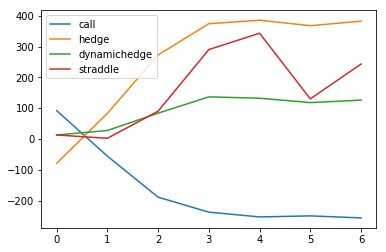

In [11]:
retuns_df.plot()